<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#one-ff-env" data-toc-modified-id="one-ff-env-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>one-ff env</a></span></li><li><span><a href="#retrieve" data-toc-modified-id="retrieve-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>retrieve</a></span></li><li><span><a href="#function" data-toc-modified-id="function-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>function</a></span></li><li><span><a href="#graphs" data-toc-modified-id="graphs-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>graphs</a></span><ul class="toc-item"><li><span><a href="#angle-vs.-distance,-dv" data-toc-modified-id="angle-vs.-distance,-dv-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>angle vs. distance, dv</a></span></li><li><span><a href="#angle-vs.-distance,-dw" data-toc-modified-id="angle-vs.-distance,-dw-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>angle vs. distance, dw</a></span></li><li><span><a href="#angle-vs.-memory,-dv" data-toc-modified-id="angle-vs.-memory,-dv-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>angle vs. memory, dv</a></span></li><li><span><a href="#angle-vs.-memory,-dw" data-toc-modified-id="angle-vs.-memory,-dw-4.4"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>angle vs. memory, dw</a></span></li><li><span><a href="#distance-vs.-memory,-dv" data-toc-modified-id="distance-vs.-memory,-dv-4.5"><span class="toc-item-num">4.5&nbsp;&nbsp;</span>distance vs. memory, dv</a></span></li><li><span><a href="#distance-vs.-memory,-dw" data-toc-modified-id="distance-vs.-memory,-dw-4.6"><span class="toc-item-num">4.6&nbsp;&nbsp;</span>distance vs. memory, dw</a></span></li></ul></li></ul></div>

In [2]:
from functions.process_raw_data import*
from SB3_functions import*
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import numpy as np
import matplotlib
from matplotlib import rc
import pandas as pd
import os
import torch
import torch.nn as nn
from stable_baselines3 import PPO, A2C, SAC, TD3
from stable_baselines3.common.monitor import Monitor
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
rc('animation', html='jshtml')
matplotlib.rcParams['animation.embed_limit'] = 2**128
torch.set_printoptions(sci_mode=False)
np.set_printoptions(suppress=True)
pd.set_option('display.float_format', lambda x: '%.5f' % x)

# one-ff env

In [ ]:
# obs = [angle, distance, memory, angle2, distance2, memory2, ...]
# before = [angle, angle2 ..., distance, distance2, ... memory, memory2]

class MultiFF(Env):
  def __init__(self):
      super(MultiFF, self).__init__()
      self.num_ff = 200
      self.arena_radius = 1000
      self.episode_len = 1024 
      self.dt = 0.25 
      #self.current_episode = 0
      #self.action_space = spaces.Box(low=-1., high=1., shape=(2,),dtype=np.float32)
      self.action_space = spaces.Box(low=-1., high=1., shape=(2,),dtype=np.float32)
      self.obs_ff = 1
      self.observation_space = spaces.Box(low=-1., high=1., shape=(self.obs_ff*4,),dtype=np.float32)
      self.terminal_vel = 0.01
      #self.pro_noise_std = 0.005
      self.vgain = 200
      self.wgain = pi/2
      self.reward_per_ff = 100
      #self.time_cost = 0.005
      #self.total_time = 0
      #self.zero_action = False
      #self.target_update_counter_num = 20
      #self.reward_per_episode = []
      #self.update_slots = True
      #self.closest_ff_distance = 200
      self.pro_noise_std = 0.005
      self.epi_num = -1
      self.has_sped_up_before = False
      self.full_memory = 4
      self.internal_noise_factor = 1.5
      self.ff_memory_all = torch.ones([self.num_ff,])*self.full_memory
      self.invisible_distance = 400
      self.invisible_angle = 2*pi/9
      self.reward_boundary = 25
      






  def reset(self):
    self.epi_num += 1
    print("\n episode: ", self.epi_num)
    self.num_targets = 0
    #self.past_speeds = []
    self.time = 0
    #self.counter = 0
    #self.current_target_index = torch.tensor([999], dtype=torch.int32)
    #self.previous_target_index = self.current_target_index
    self.ff_flash = []
    self.has_sped_up_before = False
    
    for i in range(self.num_ff):
      num_intervals = 1500
      first_flash = torch.rand(1)
      intervals = torch.poisson(torch.ones(num_intervals-1)*3)
      t0 = torch.cat((first_flash, first_flash+torch.cumsum(intervals, dim=0)+torch.cumsum(torch.ones(num_intervals-1)*0.3, dim=0)))
      t1 = t0 + torch.ones(num_intervals)*0.3
      self.ff_flash.append(torch.stack((t0, t1), dim=1))

    self.ffr = torch.sqrt(torch.rand(self.num_ff))*self.arena_radius # The radius of the arena changed from 1000 cm/s to 200 cm/s
    self.fftheta = torch.rand(self.num_ff)*2*pi
    #self.ffrt = torch.stack((self.ffr, self.fftheta), dim=1) 
    self.ffx = torch.cos(self.fftheta) * self.ffr
    self.ffy = torch.sin(self.fftheta) * self.ffr
    self.ffxy = torch.stack((self.ffx, self.ffy), dim=1)
    self.ffx2 = self.ffx.clone()
    self.ffy2 = self.ffy.clone()
    self.ffxy2 = torch.stack((self.ffx2, self.ffy2), dim=1)
    #self.ff_info={}
    #self.update_slots = True
    self.agentx = torch.tensor([0])
    self.agenty = torch.tensor([0])
    self.agentr = torch.zeros(1)
    self.agentxy = torch.tensor([0, 0])
    self.agentheading = torch.zeros(1).uniform_(0, 2*pi)
    self.dv = torch.zeros(1).uniform_(-0.05, 0.05) 
    self.dw = torch.zeros(1)
    self.end_episode = False 
    self.obs = self.beliefs().numpy()
    #self.chunk_50s = 1
    self.episode_reward = 0
    #self.stop_rewarding_speed = False
    #self.current_obs_steps = 0
    self.ff_memory_all = torch.ones([self.num_ff,])
    return self.obs






  def calculate_reward(self):
      #action_cost=((self.previous_action[1]-self.action[1])**2+(self.previous_action[0]-self.action[0])**2)*self.mag_cost
      # To incorporate action_cost, we need to incorporate previous_action into decision_info
      #self.total_time += 1
      # In addition to rewarding the monkey for capturing the firefly, we also use different phases of rewards to teach monkey specific behaviours
      #reward = -self.time_cost
      reward = 0
      # Reward shaping
      # Phase I: reward the agent for learning to stop 
      # Always: reward the agent for capturing fireflies
      self.num_targets = 0
      if abs(self.sys_vel[1]) <= self.terminal_vel:
        captured_ff_index = (self.ff_distance_all <= self.reward_boundary).nonzero().reshape(-1).tolist()
        self.captured_ff_index = captured_ff_index
        num_targets = len(captured_ff_index)
        self.num_targets = num_targets
        if num_targets > 0: # If the monkey hs captured at least 1 ff
          # Calculate reward
          reward = reward + self.reward_per_ff * num_targets
          # Replace the captured ffs with ffs of new locations
          self.ffr[captured_ff_index]= torch.sqrt(torch.rand(num_targets))*self.arena_radius
          self.fftheta[captured_ff_index]= torch.rand(num_targets)*2*pi
          #self.ffrt = torch.stack((self.ffr, self.fftheta), dim=1) 
          self.ffx[captured_ff_index] = torch.cos(self.fftheta[captured_ff_index]) * self.ffr[captured_ff_index]
          self.ffy[captured_ff_index] = torch.sin(self.fftheta[captured_ff_index]) * self.ffr[captured_ff_index]
          self.ffxy = torch.stack((self.ffx, self.ffy), dim=1)
          self.ffx2[captured_ff_index] = self.ffx[captured_ff_index].clone()
          self.ffy2[captured_ff_index] = self.ffy[captured_ff_index].clone()
          self.ffxy2 = torch.stack((self.ffx2, self.ffy2), dim=1)
          # Delete the information from self.ff_info
          #[self.ff_info.pop(key) for key in captured_ff_index if (key in self.ff_info)]
          #self.current_target_index = torch.tensor([999], dtype=torch.int32)
          #self.previous_target_index = self.current_target_index
          # Reward the firefly based on the average speed before capturing the firefly
          ##reward = reward + sum(self.past_speeds)/len(self.past_speeds)
          #print(round(self.time, 2), "sys_vel: ", [round(i, 4) for i in self.sys_vel.tolist()], "obs: ", list(np.round(self.obs, decimals = 2)), "n_targets: ",  num_targets)
          print(round(self.time, 2), "sys_vel: ", [round(i, 4) for i in self.sys_vel.tolist()], "n_targets: ",  num_targets)
          #self.update_slots = True
          #self.stop_rewarding_speed = True
        #elif self.has_sped_up_before == True:
        # based on Ruiyi's formula, using the distance of the closest ff in obs
        #reward += math.exp(-((self.ff_current[1, 0]**2)*(25/1.5)**2)/2)
        #self.has_sped_up_before = False
      return reward







  def step(self, action):
    self.time += self.dt
    action=torch.tensor(action)
    action[1] = action[1]/2+0.5
    self.sys_vel=action.clone()
    self.state_step(action)
    self.obs = self.beliefs().numpy()
    reward=self.calculate_reward()
    self.episode_reward += reward
    
    if self.time >= self.episode_len*self.dt:
      self.end_episode = True
      #self.current_episode += 1
      print("Reward for the episode: ", self.episode_reward)
    #print("action: ", torch.round(action, decimals = 3), "obs: ", np.round(self.obs, decimals = 3), "Reward: ", round(reward, 3))
    return self.obs, reward, self.end_episode, {}




  def state_step(self,action):
    vnoise=torch.distributions.Normal(0,torch.ones([1,1])).sample()*self.pro_noise_std 
    wnoise=torch.distributions.Normal(0,torch.ones([1,1])).sample()*self.pro_noise_std
    self.dw_normed = (action[0]+wnoise)
    self.dv_normed = (action[1]+vnoise)
    self.dw = (action[0]+wnoise)*self.wgain*self.dt
    self.agentheading = self.agentheading + self.dw.item()
    self.dv =  (action[1]+vnoise)*self.vgain*self.dt
    self.dx= torch.cos(self.agentheading)*self.dv
    self.dy= torch.sin(self.agentheading)*self.dv
    self.agentx = self.agentx + self.dx.item()
    self.agenty = self.agenty + self.dy.item()
    self.agentxy = torch.cat((self.agentx, self.agenty))
    self.agentr = vector_norm(self.agentxy)
    self.agenttheta = torch.atan2(self.agenty, self.agentx)  
                               
    if self.agentr >= self.arena_radius:
      self.agentr = 2*self.arena_radius-self.agentr
      self.agenttheta = self.agenttheta + pi
      self.agentx = (self.agentr*torch.cos(self.agenttheta)).reshape(1,)
      self.agenty = (self.agentr*torch.sin(self.agenttheta)).reshape(1,)
      self.agentxy = torch.cat((self.agentx, self.agenty))
      self.agentheading = self.agenttheta - pi
    while self.agentheading >= 2*pi:
      self.agentheading = self.agentheading - 2*pi
    while self.agentheading < 0:
      self.agentheading = self.agentheading + 2*pi   








  def beliefs(self): 

    # Make a tensor containing the relative distance of all fireflies to the agent
    self.ff_distance_all = vector_norm(self.ffxy - self.agentxy, dim=1)
    # Make a tensor containing the relative (real) angle of all fireflies to the agent
    ffradians = torch.atan2(self.ffy-self.agenty, self.ffx-self.agentx)
    angle0 = ffradians - self.agentheading
    angle0[angle0 > pi] = angle0[angle0 > pi] - 2*pi
    angle0[angle0 < -pi] = angle0[angle0 < -pi] + 2*pi
    # Adjust the angle based on reward boundary
    angle1 = torch.abs(angle0)-torch.abs(torch.arcsin(torch.div(self.reward_boundary, torch.clip( self.ff_distance_all, self.reward_boundary, 400) ))) # use torch clip to get valid arcsin input
    angle2 = torch.clip(angle1,0,pi)
    ff_angle_all = torch.sign(angle0)* angle2
    # Update the tensor containing the uncertainties of all fireflies to the agent
    visible_ff = torch.logical_and( self.ff_distance_all < self.invisible_distance, torch.abs(ff_angle_all) < self.invisible_angle)
    self.visible_ff_indices0 = visible_ff.nonzero().reshape(-1)
    for index in self.visible_ff_indices0:
      ff = self.ff_flash[index]
      if not torch.any(torch.logical_and(ff[:, 0] <= self.time, ff[:, 1] >= self.time)):
        visible_ff[index] = False
    self.visible_ff_indices = visible_ff.nonzero().reshape(-1)
    # Update memory
    self.ff_memory_all -= 1
    self.ff_memory_all[self.visible_ff_indices] = self.full_memory
    self.ff_memory_all = torch.clamp(self.ff_memory_all, 0, self.full_memory)
    # Calculate the uncertainties that will be added to relative distance and angle based on memory
    ff_uncertainty_all = (self.full_memory-self.ff_memory_all)*self.internal_noise_factor
    self.ffx2 = self.ffx2 + torch.normal(torch.zeros([self.num_ff,]), ff_uncertainty_all)
    self.ffy2 = self.ffy2 + torch.normal(torch.zeros([self.num_ff,]), ff_uncertainty_all)
    self.ffx2[self.visible_ff_indices] = self.ffx[self.visible_ff_indices].clone()
    self.ffy2[self.visible_ff_indices] = self.ffy[self.visible_ff_indices].clone()
    self.ffxy2 = torch.stack((self.ffx2, self.ffy2), dim=1)
    # find ffs that are in memory
    self.ff_in_memory_indices = (self.ff_memory_all > 0).nonzero().reshape(-1)
    # Consider the case where there are fewer than self.obs_ff fireflies that are in memory
    

   
    if torch.numel(self.ff_in_memory_indices) >= self.obs_ff:
      # Rank the ff whose "memory" is creater than 0 based on distance
      sorted_indices =  torch.topk(-self.ff_distance_all[self.ff_in_memory_indices], self.obs_ff).indices
      self.topk_indices = self.ff_in_memory_indices[sorted_indices]
      self.ffxy2_topk = self.ffxy2[self.topk_indices]
      self.ff_distance_topk = vector_norm(self.ffxy2_topk - self.agentxy, dim=1)
      # Calculate relative angles 
      ffradians = torch.atan2(self.ffxy2_topk[:,1]-self.agenty, self.ffxy2_topk[:,0]-self.agentx)
      angle0 = ffradians - self.agentheading
      angle0[angle0 > pi] = angle0[angle0 > pi] - 2*pi
      angle0[angle0 < -pi] = angle0[angle0 < -pi] + 2*pi
      self.ff_angle_topk_2 = angle0.clone()
      # Calculate relative angles of all ffs based on reward boundaries
      # Adjust the angle based on reward boundary
      angle1 = torch.abs(angle0)-torch.abs(torch.arcsin(torch.div(self.reward_boundary, torch.clip(self.ff_distance_topk, self.reward_boundary, 400) ))) # use torch clip to get valid arcsin input
      angle2 = torch.clip(angle1,0,pi)
      ff_angle_topk_3 = torch.sign(angle0)* angle2
      # Concatenate distance, angle, and memory
      ff_array = torch.stack((self.ff_angle_topk_2, ff_angle_topk_3, self.ff_distance_topk,  self.ff_memory_all[self.topk_indices]), dim=0)
    

    else:
      ff_array = torch.tensor([[0], [0], [self.invisible_distance], [0]]).repeat([1, self.obs_ff])
      self.topk_indices = torch.tensor([])



    # ff_array[0:2,:] = ff_array[0:2,:]/pi
    # ff_array[2,:] = (ff_array[2,:]/self.invisible_distance-0.5)*2
    # ff_array[3,:] = (ff_array[3,:]/20-0.5)*2
    self.ff_array = ff_array.clone()
    return torch.flatten(ff_array.transpose(0, 1))


env = MultiFF() 
env.reset() 

sac_model = SAC("MlpPolicy", 
            env,
            buffer_size=int(1e6),
            batch_size=1024,
            device='auto',
            verbose=False,
            train_freq=100,
            learning_starts = int(10),
            target_update_interval=20,
            learning_rate=1e-2,
            gamma=0.9999,
            policy_kwargs=dict(activation_fn=nn.ReLU, net_arch=[64, 64])
                )


# retrieve

In [17]:
retrieve_dir = "SB3_data/SB3_Aug_11_2/"
# eval rewards: 101100 per episode
path = os.path.join(retrieve_dir, 'best_model.zip')
sac_model = sac_model.load(path,env=env)  

# function

In [38]:
def look_inside_brain(sample_size = 1000, 
                      full_memory = 4, 
                      color_variable = "dv",
                      invisible_distance = 400, 
                      const_distance = None, 
                      const_angle = None, 
                      const_memory = None, 
                      num_default_ff = 0, 
                      norm_input = False, 
                      plot_in_xy_coord = False,
                      use_angle_to_boundary = False):
  # Let's try if the second slot is with a placeholder

  fig, ax = plt.subplots()

  if const_distance:
    distances = np.ones(sample_size)*const_distance
    angle2center = np.random.uniform(low=-pi, high=pi, size=sample_size,)
    angle_temp = np.abs(angle2center)-np.abs(np.arcsin(np.divide(25, np.clip(distances, 25, 400) ))) 
    angle2boundary = np.clip(angle_temp,0,pi)
    angle2boundary = np.sign(angle2center)* angle2boundary
    memories = np.random.randint(low=0, high=21, size=[sample_size,])
    plt.title("Angle-to-center vs Memory, colored by " + color_variable, y=1.08)
    plt.xlabel("Memory", labelpad=30) #
    plt.ylabel("Angle to center (rad)", labelpad=30)
  elif const_angle:
    distances = np.random.uniform(low=0.0, high=400.0, size=[sample_size,])
    memories = np.random.randint(low=0, high=21, size=[sample_size,])
    angle2center = np.ones([sample_size,]) * const_angle
    angle_temp = np.abs(angle2center)-np.abs(np.arcsin(np.divide(25, np.clip(distances, 25, 400) ))) 
    angle2boundary = np.clip(angle_temp,0,pi)
    angle2boundary = np.sign(angle2center)* angle2boundary
    plt.xlabel("Memory", labelpad=30)
    plt.ylabel("Distance (cm)", labelpad=30)
    plt.title("Memory vs Distance, colored by " + color_variable, y=1.08)
  elif const_memory:
    distances = np.random.uniform(low=0.0, high=400.0, size=[sample_size,])
    angle2center = np.random.uniform(low=-pi, high=pi, size=sample_size,)
    angle_temp = np.abs(angle2center)-np.abs(np.arcsin(np.divide(25, np.clip(distances, 25, 400) ))) 
    angle2boundary = np.clip(angle_temp,0,pi)
    angle2boundary = np.sign(angle2center)* angle2boundary
    memories = np.ones(sample_size)*const_memory
    plt.title("Angle-to-center vs Distance, colored by " + color_variable, y=1.08)
    plt.xlabel("Egocentric x-coord (cm) ", labelpad=30) #v
    plt.ylabel("Egocentric y-coord (cm)", labelpad=30)
      
    
  stacked_array = np.stack((angle2center, angle2boundary, distances,  memories), axis=1)

  if num_default_ff > 0:
    for i in range(len(num_default_ff)):
      placeholders = np.tile(np.array([[0], [0], [400], [1]]), sample_size).T
      stacked_array = np.concatenate([stacked_array, placeholders], axis=1)

  if norm_input == True:
    stacked_array[0::4] = stacked_array[0::4]/pi
    stacked_array[1::4] = stacked_array[1::4]/pi
    stacked_array[2::4] = (stacked_array[2::4]/invisible_distance-0.5)*2
    stacked_array[3::4] = (stacked_array[3::4]/full_memory-0.5)*2

  all_actions = np.zeros([sample_size, 2])
  for i in range(sample_size):
    obs = stacked_array[i]
    action, _ = sac_model.predict(obs, deterministic=True)
    all_actions[i] = action.copy()

  if color_variable == "dv":
    color_var = all_actions[:,1]+1
    cmap = cm.viridis_r
    norm = matplotlib.colors.Normalize(vmin=0, vmax=200)
    cax = fig.add_axes([0.95, 0.4, 0.05, 0.43])
    cbar = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap),
                cax=cax, orientation='vertical')
    cbar.ax.set_title('dv(cm/s)', ha='left', y=1.04)
    cbar.ax.tick_params(axis='y', color='white', direction="in", right=True,length=5, width=1.5)
    cbar.outline.set_visible(False)
  else:
    color_var = all_actions[:,0]
    cmap = cm.viridis_r
    norm = matplotlib.colors.Normalize(vmin=-pi, vmax=pi)
    cax = fig.add_axes([0.95, 0.4, 0.05, 0.43])
    cbar = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap),
          cax=cax, orientation='vertical')
    cbar.ax.set_title('dw(rad/s)', ha='left', y=1.04)
    cbar.ax.tick_params(axis='y', color='white', direction="in", right=True,length=5, width=1.5)
    cbar.outline.set_visible(False)



  if const_distance:
    if use_angle_to_boundary == False:
      ax.scatter(stacked_array[:,3], stacked_array[:,0], s=2, c= color_var, cmap="viridis_r")
    else:
      ax.scatter(stacked_array[:,3], stacked_array[:,1], s=2, c= color_var, cmap="viridis_r")

  elif const_angle:
    ax.scatter(stacked_array[:,3], stacked_array[:,2], s=2, c= color_var, cmap="viridis_r")

  elif const_memory:
    if plot_in_xy_coord == True:
      all_x = np.multiply(np.cos(angle2center+pi/2), distances)
      all_y = np.multiply(np.sin(angle2center+pi/2), distances)
      valid_indices = np.where(all_y > 0)[0]
      ax.scatter(all_x[valid_indices], all_y[valid_indices], s=2, c= color_var[valid_indices], cmap="viridis_r")
    else:
      if use_angle_to_boundary == False:
        ax.scatter(stacked_array[:,0], stacked_array[:,2], s=2, c= color_var, cmap="viridis_r")
      else:
        ax.scatter(stacked_array[:,1], stacked_array[:,2], s=2, c= color_var, cmap="viridis_r")



  plt.show()

# graphs

## angle vs. distance, dv

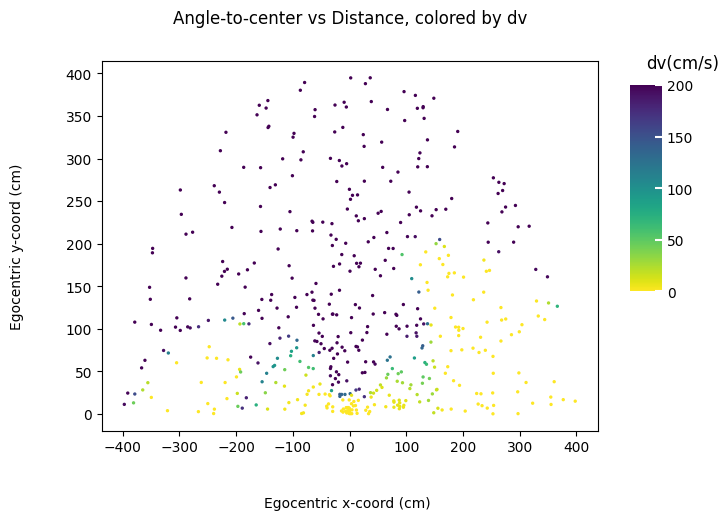

In [39]:
look_inside_brain(sample_size = 1000,const_memory = 4, plot_in_xy_coord=True)

## angle vs. distance, dw

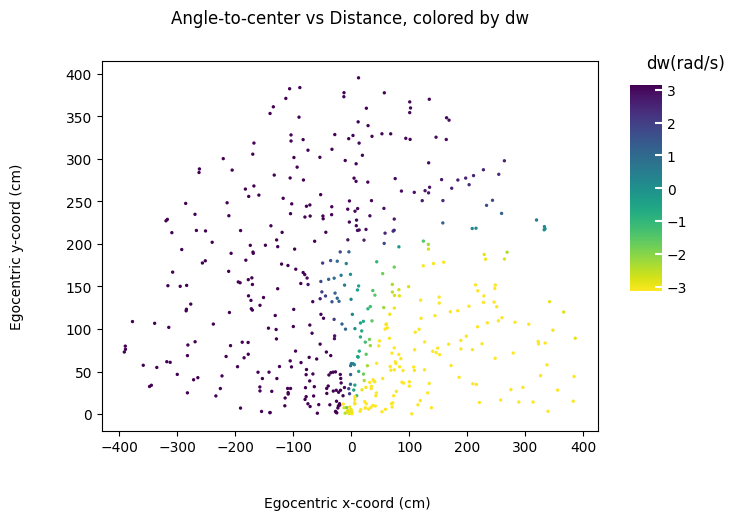

In [40]:
look_inside_brain(sample_size = 1000,const_memory = 4, color_variable="dw", plot_in_xy_coord=True)

## angle vs. memory, dv

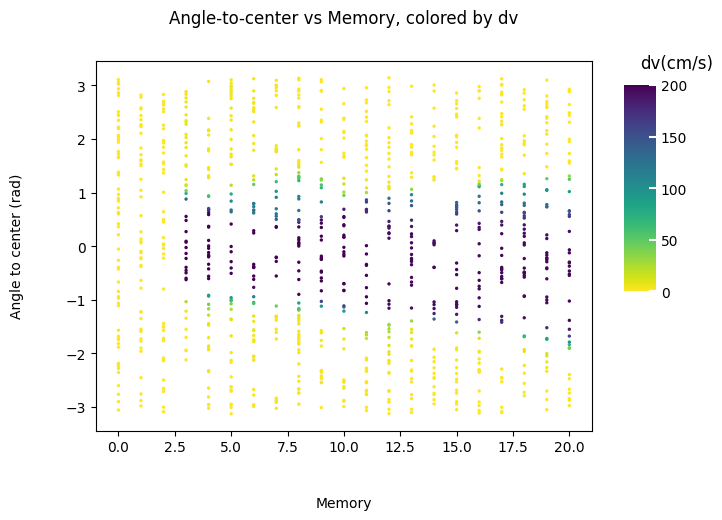

In [41]:
look_inside_brain(sample_size = 1000, const_distance = 100, color_variable="dv", plot_in_xy_coord=True)

## angle vs. memory, dw

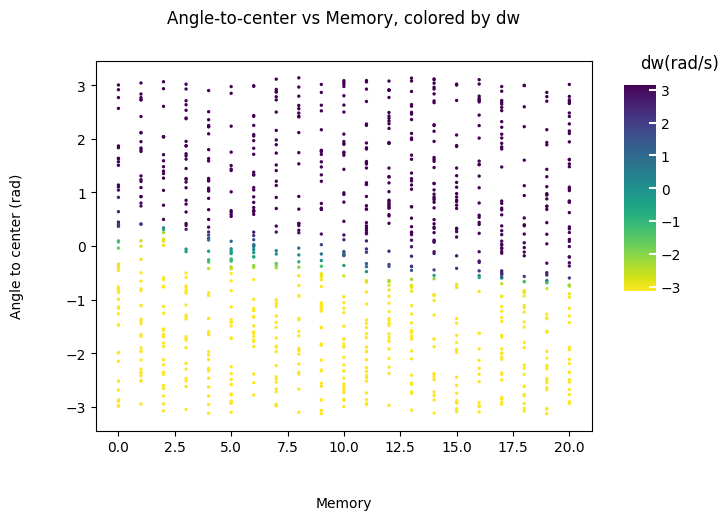

In [42]:
look_inside_brain(sample_size = 1000, const_distance = 100, color_variable="dw", plot_in_xy_coord=True)

## distance vs. memory, dv

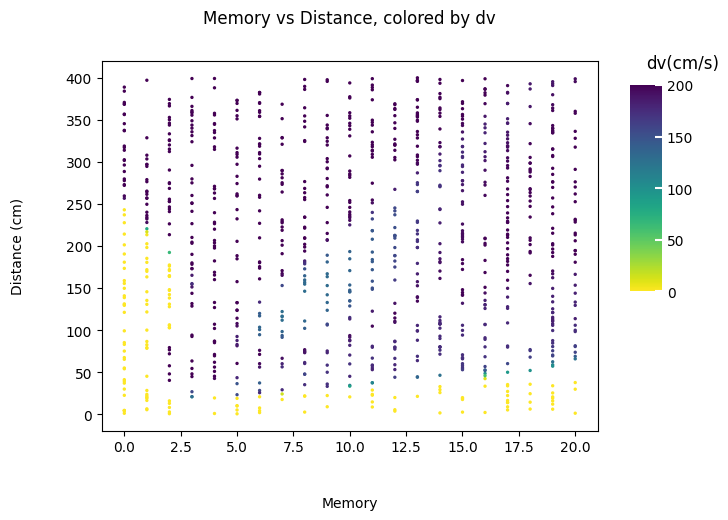

In [43]:
look_inside_brain(sample_size = 1000, const_angle = 0.5, color_variable="dv", plot_in_xy_coord=True)

## distance vs. memory, dw

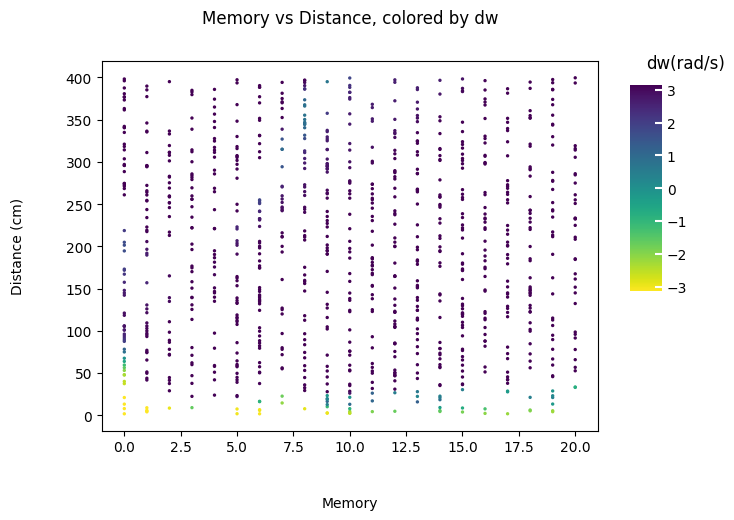

In [44]:
look_inside_brain(sample_size = 1000, const_angle = 0.5, color_variable="dw", plot_in_xy_coord=True)